In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install easyocr

In [21]:
!pip install python-Levenshtein

In [3]:
from google.colab import files

uploaded = files.upload()

Saving Data_preprocessing.py to Data_preprocessing.py
Saving transliteration.txt to transliteration.txt


In [4]:
import Levenshtein
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf

In [ ]:
import easyocr
reader = easyocr.Reader(['hi']) # need to run only once to load model into memory

In [ ]:
def OCR(file_name, dir_path = "/content/drive/MyDrive/"):
  img_file = dir_path + file_name
  return reader.readtext(img_file, detail = 0)

In [5]:
def saveVariables(variables): #where 'variables' is a list of variables
    with open("./drive/MyDrive/DS_Proj_Var.txt", 'wb+') as file:
        pickle.dump(variables, file)

def retrieveVariables(filename):
    variables = []
    with open(str(filename), 'rb') as file:
        variables = pickle.load(file)
    return variables

In [6]:
#Reading dataset
dataset = pd.read_csv("transliteration.txt",delimiter = "\t",header=None,encoding='utf-8',na_filter = False)

#Splitting English words in X and Hindi words in y
X = dataset.iloc[:,0]
y = dataset.iloc[:,-1]

print(y)

0          खुशबू
1          खुशबू
2          खुशबू
3          खुशबू
4           तेरा
          ...   
30818      जाँदी
30819       एरदे
30820       लेवा
30821     चावाइं
30822    जत्तिया
Name: 1, Length: 30823, dtype: object


In [7]:
#importing the preprocessed data 
#The preprocessing is done in a file named Data_preprocessing
import Data_preprocessing

#source_int_text is the English words' processed vector. (Word is Converted to integer vector)
#target_int_text is the Hindi words' processed vector.
#source_vocab_to_int and  source_int_to_vocab are the English dictionaries
#target_vocab_to_int and  target_int_to_vocab are the Hindi dictionaries

target_int_text, source_int_text, target_vocab_to_int, source_vocab_to_int,target_int_to_vocab,source_int_to_vocab = Data_preprocessing.preprocess(X,y)

In [8]:
print(X)

0        khushboo
1        khushbuu
2         khushbu
3         khusbhu
4            tera
           ...   
30818      jaandi
30819       erade
30820        lewa
30821    chaawain
30822     jattiya
Name: 0, Length: 30823, dtype: object


In [9]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [10]:
# We set input vector size to the size of longest sentence (sentence with maximum length) in out dataset.
max_length_src, max_length_tar = max_length(source_int_text), max_length(target_int_text)
    
# We need to add padding other sentences before using them. We will pad the input and output tensor to max-length
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(source_int_text, maxlen=max_length_src, padding='post')
  
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_int_text, maxlen=max_length_tar, padding='post')

In [12]:
from sklearn.model_selection import train_test_split

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.05)

len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(29281, 29281, 1542, 1542)

In [13]:
BUFFER_SIZE = len(source_int_text)
BATCH_SIZE = 32
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(source_vocab_to_int)
vocab_tar_size = len(target_vocab_to_int)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [14]:
def gru(units):
  return tf.keras.layers.GRU(units, return_sequences=True, return_state=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform')

# Encoder Unit
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = gru(self.enc_units)

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)        
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

# Decoder Unit
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = gru(self.dec_units)
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.W1 = tf.keras.layers.Dense(self.dec_units)
    self.W2 = tf.keras.layers.Dense(self.dec_units)
    self.V = tf.keras.layers.Dense(1)
        
  def call(self, x, hidden, enc_output):
    #  enc_output shape == (batch_size, max_length, hidden_size)
        
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
    score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * enc_output
    context_vector = tf.reduce_sum(context_vector, axis=1)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size * 1, vocab)
    x = self.fc(output)

    return x, state, attention_weights

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.dec_units))

In [15]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [16]:
optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
  mask = 1-np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

In [17]:
import os

# On loacl machine dir changed to 'training_checkpoints/' to fit the loaction
checkpoint_dir = './drive/MyDrive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [18]:
def evaluate(word, encoder, decoder, max_length_src, max_length_tar):

    _, inp, target_vocab_to_int, source_vocab_to_int,target_int_to_vocab,source_int_to_vocab = Data_preprocessing.preprocess(['dummy'],[word])
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inp[0]], maxlen=max_length_src, padding='post')
    
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([1], 0)

    for t in range(max_length_tar):
      predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

      predicted_id = tf.argmax(predictions[0]).numpy()

      if predicted_id == 1:
          return result, inp
      
      result += target_int_to_vocab[predicted_id] + ''

      # the predicted ID is fed back into the model
      dec_input = tf.expand_dims([predicted_id], 0)

    return result, inp

In [19]:
print(y[0])
print(X[0])

खुशबू
khushboo


In [20]:
import time

EPOCHS = 2
hin_word = y[0]
eng_word = X[0]
print('Hindi Word To Be Translated: ', hin_word)

losses = []
results = []
lev_ratio = []
lev_jaro = []
lev_dist = []

for epoch in range(EPOCHS):
  start = time.time()
    
  hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset):
    loss = 0
        
    with tf.GradientTape() as tape:
      enc_output, enc_hidden = encoder(inp, hidden)

      dec_hidden = enc_hidden

      dec_input = tf.expand_dims([1] * BATCH_SIZE, 1)       

      # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    total_loss += batch_loss

    variables = encoder.variables + decoder.variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    encoder_model = encoder
    decoder_model = decoder

#   with open('encoder_model.json', 'w', encoding='utf8') as f:
#        f.write(encoder_model.to_json())
#    encoder_model.save_weights('encoder_model_weights.h5')
#
#    with open('decoder_model.json', 'w', encoding='utf8') as f:
#        f.write(decoder_model.to_json())
#    decoder_model.save_weights('decoder_model_weights.h5')

    if batch % 100 == 0:
        print('Epoch {} Batch {}: Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
        
        result, inp = evaluate(hin_word, encoder, decoder, max_length_src, max_length_tar)

        losses.append(batch_loss.numpy())

        results.append(result)

        ratio = Levenshtein.ratio(eng_word, result)
        lev_ratio.append(ratio)

        jaro = Levenshtein.jaro_winkler(eng_word, result)
        lev_jaro.append(jaro)

        dist = Levenshtein.distance(eng_word, result)
        lev_dist.append(dist)

        var_to_save = [losses, results, lev_ratio, lev_jaro, lev_dist]
        saveVariables(var_to_save)

        checkpoint.save(file_prefix = checkpoint_prefix)

        print('English Translation: {}'.format(result))
        print('Similarity: {}'.format(ratio))
        print('Jaro Winkler Similarity: {}'.format(jaro))
        print('Absolute Levenshtein Distance: {}'.format(dist))
        print('------------------------')

Hindi Word To Be Translated:  खुशबू
Epoch 1 Batch 0: Loss 1.0070
English Translation: aaaaaaaaaaaaaaaaaaaaaaa
Similarity: 0.0
Jaro Winkler Similarity: 0.0
Absolute Levenshtein Distance: 23
------------------------
Epoch 1 Batch 100: Loss 0.7139
English Translation: baaaaaaaaaaaaaaaaaaaaaa
Similarity: 0.06451612903225806
Jaro Winkler Similarity: 0.0
Absolute Levenshtein Distance: 23
------------------------
Epoch 1 Batch 200: Loss 0.6148
English Translation: khuuuuuuuuuuuuuuuuuuuuu
Similarity: 0.1935483870967742
Jaro Winkler Similarity: 0.651268115942029
Absolute Levenshtein Distance: 20
------------------------
Epoch 1 Batch 300: Loss 0.3675
English Translation: kushubo
Similarity: 0.8
Jaro Winkler Similarity: 0.8071428571428572
Absolute Levenshtein Distance: 3
------------------------
Epoch 1 Batch 400: Loss 0.1321
English Translation: khushuu
Similarity: 0.6666666666666666
Jaro Winkler Similarity: 0.8898809523809524
Absolute Levenshtein Distance: 3
------------------------
Epoch 1 Ba

In [22]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [23]:
hin_word = y[0]
result, inp = evaluate(hin_word, encoder, decoder, max_length_src, max_length_tar)
print(result)

khushu


In [24]:
Variables = retrieveVariables("./drive/MyDrive/DS_Proj_Var.txt")
losses = Variables[0]
results = Variables[1]
lev_ratio = Variables[2]
lev_jaro = Variables[3]
lev_dist = Variables[4]

In [26]:
ratio = 0
jaro = 0
dist = 0

for i in range(len(y)):

    hin_word = y[i]
    eng_word = X[i]

    result, inp = evaluate(hin_word, encoder, decoder, max_length_src, max_length_tar)

    ratio += Levenshtein.ratio(eng_word, result)
    jaro += Levenshtein.jaro_winkler(eng_word, result)
    dist += Levenshtein.distance(eng_word, result)

avg_ratio = ratio/len(y)
avg_jaro = jaro/len(y)
avg_dist = dist/len(y)

In [27]:
print('Final Ratio Parameter: {}'.format(avg_ratio))
print('Final Jaro Parameter: {}'.format(avg_jaro))
print('Final Distance Parameter: {}'.format(avg_dist))

Final Ratio Parameter: 0.9206224973021648
Final Jaro Parameter: 0.9587824697783452
Final Distance Parameter: 0.8092658080005191


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


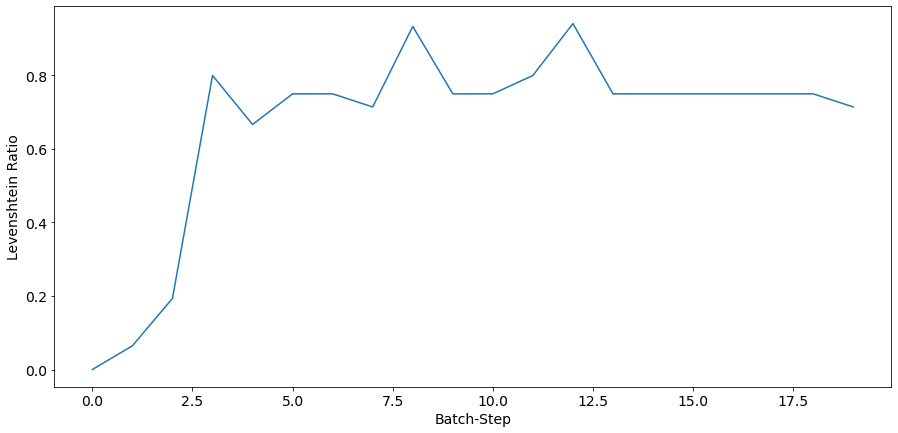

In [34]:
import matplotlib.pyplot as plt
import seaborn as sb

x = [i for i in range(len(lev_ratio))]

# Setting the figure size
plt.figure(figsize=(15,7))

sb.lineplot(x, lev_ratio)

# Adjusting label size in the x-axis
plt.tick_params(axis='x', which='major', labelsize=14)
plt.xlabel('Batch-Step', fontsize = 14)

# Adjusting label size in the x-axis
plt.tick_params(axis='y', which='major', labelsize=14)
plt.ylabel("Levenshtein Ratio", fontsize = 14)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


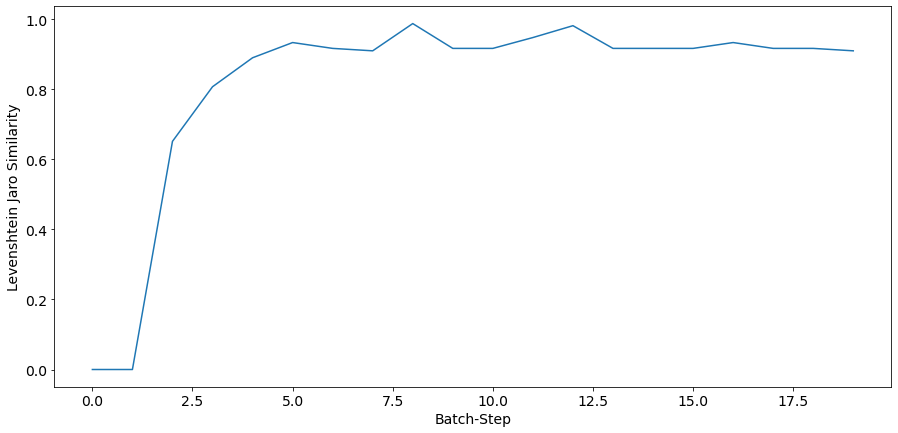

In [35]:
# Setting the figure size
plt.figure(figsize=(15,7))

sb.lineplot(x, lev_jaro)

# Adjusting label size in the x-axis
plt.tick_params(axis='x', which='major', labelsize=14)
plt.xlabel('Batch-Step', fontsize = 14)

# Adjusting label size in the x-axis
plt.tick_params(axis='y', which='major', labelsize=14)
plt.ylabel("Levenshtein Jaro Similarity", fontsize = 14)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


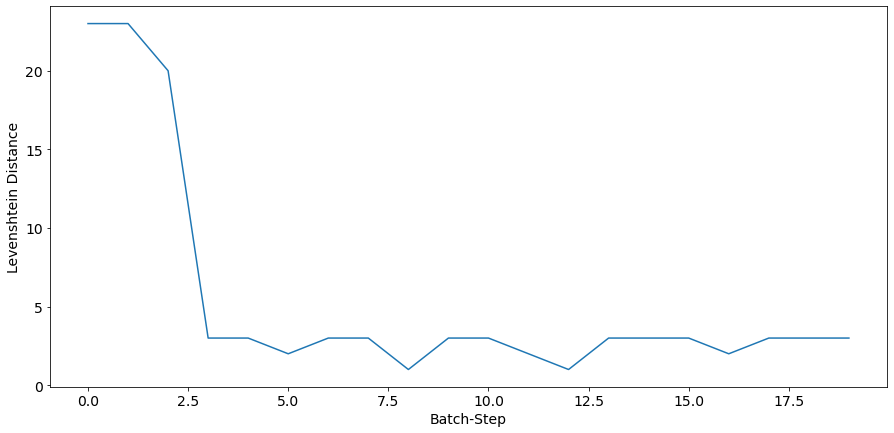

In [36]:
# Setting the figure size
plt.figure(figsize=(15,7))

sb.lineplot(x, lev_dist)

# Adjusting label size in the x-axis
plt.tick_params(axis='x', which='major', labelsize=14)
plt.xlabel('Batch-Step', fontsize = 14)

# Adjusting label size in the x-axis
plt.tick_params(axis='y', which='major', labelsize=14)
plt.ylabel("Levenshtein Distance", fontsize = 14)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


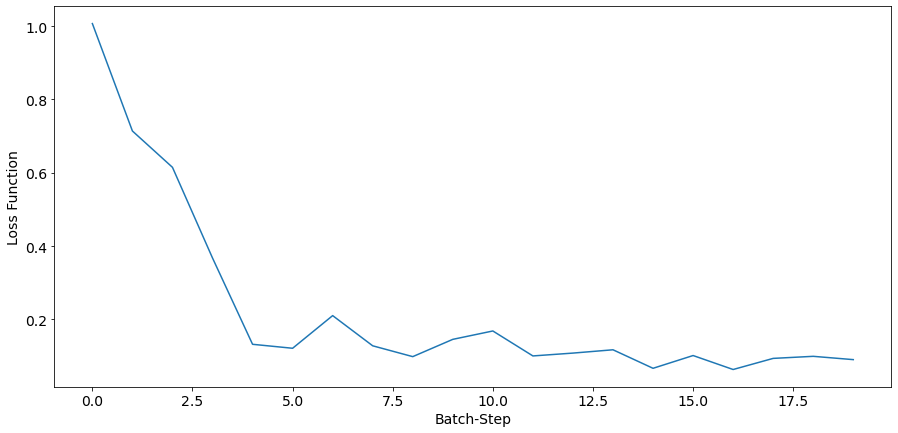

In [37]:
# Setting the figure size
plt.figure(figsize=(15,7))

sb.lineplot(x, losses)

# Adjusting label size in the x-axis
plt.tick_params(axis='x', which='major', labelsize=14)
plt.xlabel('Batch-Step', fontsize = 14)

# Adjusting label size in the x-axis
plt.tick_params(axis='y', which='major', labelsize=14)
plt.ylabel("Loss Function", fontsize = 14)
plt.show()